In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats as stat
import scipy.optimize
import math
import pickle
import pandas as pd
import seaborn as sns

In [2]:
def dual_model_sudden(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    rotation = 90/90.0
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    #rotation_est[0] = est
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est, fast_est, slow_est

def dual_model_gradual(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    rotation = 0
    for trial in range(num_trials - 1):
        if trial%64 == 0:
            rotation = rotation + 10/90.0
        if rotation > 90/90:
            rotation = 90/90
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est, fast_est, slow_est

def single_model_sudden(num_trials, A, B):
    errors = np.zeros((num_trials))
    rotation = 90/90.0
    rotation_est = np.zeros((num_trials))
    #rotation_est[0] = est
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        rotation_est[trial+1] = A * rotation_est[trial] + B*errors[trial]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est

def single_model_gradual(num_trials, A, B):
    errors = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    rotation = 0
    for trial in range(num_trials - 1):
        if trial%64 == 0:
            rotation = rotation + 10/90.0
        if rotation > 90/90:
            rotation = 90/90
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        rotation_est[trial+1] = A*rotation_est[trial] + B*errors[trial]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est


In [3]:
def single_residuals_sudden(params, num_trials, data_errors):
    model_errors = single_model_sudden(num_trials, params[0], params[1])[0]
    residual_error = -2*sum(stat.norm.logpdf(data_errors, model_errors, params[2]))
    #residual_error = np.sum(np.square(model_errors - data_errors))

    if params[0] < 0 or params[1] < 0 or params[0] > 1 or params[1] > 1:
        residual_error = residual_error + 10000000
    return residual_error

def single_residuals_gradual(params, num_trials, data_errors):
    model_errors = single_model_gradual(num_trials, params[0], params[1])[0]
    #residual_error = np.sum(np.square(model_errors - data_errors))
    residual_error = -2*sum(stat.norm.logpdf(data_errors, model_errors, params[2]))

    if params[0] < 0 or params[1] < 0 or params[0] > 1 or params[1] > 1:
        residual_error = residual_error + 10000000
    
    return residual_error

def dual_residuals_sudden(params, num_trials, data_errors):
    model_errors = dual_model_sudden(num_trials, params[0], params[1], params[2], params[3])[0]
    #residual_error = np.sum(np.square(model_errors - data_errors))
    residual_error = -2*sum(stat.norm.logpdf(data_errors, model_errors, params[4]))

    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1 or params[3] > 1:
        residual_error = residual_error + 10000000

    return residual_error

def dual_residuals_gradual(params, num_trials, data_errors):
    model_errors = dual_model_gradual(num_trials, params[0], params[1], params[2], params[3])[0]
    #residual_error = np.sum(np.square(model_errors - data_errors))
    residual_error = -2*sum(stat.norm.logpdf(data_errors, model_errors, params[4]))

    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1 or params[3] > 1:
        residual_error = residual_error + 10000000

    return residual_error

In [4]:
def fit_routine(participant, curvature):
    single_neg2ll = 1000000
    dual_neg2ll = 1000000
    for i in range(100):
        if participant%4 == 0 or participant%4 == 1:        
            fit = scipy.optimize.minimize(single_residuals_sudden, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], args = (640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), method = 'Nelder-Mead')
            #fit = scipy.optimize.basinhopping(single_residuals_sudden, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], minimizer_kwargs={'args':(640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), 'method' : 'Nelder-Mead'})
        else:
            fit = scipy.optimize.minimize(single_residuals_gradual, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], args = (640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), method = 'Nelder-Mead')            
            #fit = scipy.optimize.basinhopping(single_residuals_gradual, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], minimizer_kwargs={'args':(640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), 'method' : 'Nelder-Mead'})
        if fit.fun < single_neg2ll:            
            A = fit.x[0]
            B = fit.x[1]
            single_sigma = fit.x[2]
            single_neg2ll = fit.fun
            print("Participant, i, Single neg2ll: ", participant, i, single_neg2ll)

        if participant%4 == 0 or participant%4 == 1:        
            fit = scipy.optimize.minimize(dual_residuals_sudden, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], args = (640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), method = 'Nelder-Mead')
            #fit = scipy.optimize.basinhopping(dual_residuals_sudden, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], minimizer_kwargs={'args' : (640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), 'method' : 'Nelder-Mead'})
        else:
            fit = scipy.optimize.minimize(dual_residuals_gradual, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], args = (640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), method = 'Nelder-Mead')            
            #fit = scipy.optimize.basinhopping(dual_residuals_gradual, x0 = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)], minimizer_kwargs={'args' : (640, np.nan_to_num(np.ravel(curvature[participant][1:-1]), nan = np.nanmedian(curvature[participant][1:-1]))), 'method' : 'Nelder-Mead'})
        if fit.fun < dual_neg2ll:
            Af = fit.x[0]
            Bf = fit.x[1]
            As = fit.x[2]
            Bs = fit.x[3]

            dual_sigma = fit.x[4]
            dual_neg2ll = fit.fun
            print("Participant, i, Dual neg2ll: ", participant, i, dual_neg2ll)
    
    return [A, B, single_sigma, single_neg2ll], [Af, Bf, As, Bs, dual_sigma, dual_neg2ll] 

In [16]:
single_fits[3]

array([ 9.93113960e-01,  3.22839645e-02,  2.69776936e-02, -2.80811358e+03])

In [29]:
AIC_single = single_fits[:, -1] + 4
AIC_dual = dual_fits[:, -1] + 8

In [34]:
df = pd.DataFrame({'Participant_ID': np.arange(60), 
                   'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 15),
                   'Emphasis': np.tile(['Speed', 'Accuracy'], 30),
                   'A': single_fits[:, 0],
                   'B': single_fits[:, 1],
                   'single_sigma': single_fits[:, 2],
                   'single_neg2ll': single_fits[:, 3],
                   
                   'Af': dual_fits[:, 0],
                   'Bf': dual_fits[:, 1],
                   'As': dual_fits[:, 2],
                   'Bs': dual_fits[:, 3],                   
                   'dual_sigma': dual_fits[:, 4],
                   'dual_neg2ll': dual_fits[:, 5],
                   
                   'AIC_single': AIC_single,
                   'AIC_dual': AIC_dual
                  
                  })

In [37]:
df_selected = pd.DataFrame({'Participant_ID': np.arange(60), 
                            'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 15),
                            'Emphasis': np.tile(['Speed', 'Accuracy'], 30),
                            'dual_selected_AIC': AIC_dual < AIC_single,
                            'dual_selected_negll': df['dual_neg2ll'] < df['single_neg2ll']
                           })

In [46]:
df.to_csv('simplex_fits_startparam.csv')

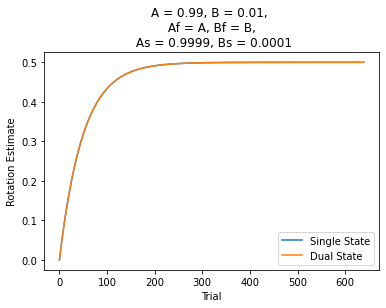

In [23]:
A = 0.99
B = 0.01
r_est_single = single_model_sudden(640, A, B)[1]
r_est_dual = dual_model_sudden(640, A, B, 0.999999, 0.000001)[1]
p1, = plt.plot(r_est_single)
p2, = plt.plot(r_est_dual)
plt.title('A = 0.99, B = 0.01, \n Af = A, Bf = B, \n As = 0.9999, Bs = 0.0001')
plt.ylabel('Rotation Estimate')
plt.xlabel('Trial')
plt.legend(('Single State', 'Dual State'))

In [5]:
A = [0.001, 0.01, 0.1, 0.5, 0.9]
B = [0.001, 0.01, 0.1, 0.5, 0.9]
sigma = [1, 0.5, 0.05]
starting_points = np.array(np.meshgrid(A, B, sigma)).reshape(3, 5*5*3).T

In [7]:
starting_points

array([[0.001, 0.001, 1.   ],
       [0.001, 0.001, 0.5  ],
       [0.001, 0.001, 0.05 ],
       [0.01 , 0.001, 1.   ],
       [0.01 , 0.001, 0.5  ],
       [0.01 , 0.001, 0.05 ],
       [0.1  , 0.001, 1.   ],
       [0.1  , 0.001, 0.5  ],
       [0.1  , 0.001, 0.05 ],
       [0.5  , 0.001, 1.   ],
       [0.5  , 0.001, 0.5  ],
       [0.5  , 0.001, 0.05 ],
       [0.9  , 0.001, 1.   ],
       [0.9  , 0.001, 0.5  ],
       [0.9  , 0.001, 0.05 ],
       [0.001, 0.01 , 1.   ],
       [0.001, 0.01 , 0.5  ],
       [0.001, 0.01 , 0.05 ],
       [0.01 , 0.01 , 1.   ],
       [0.01 , 0.01 , 0.5  ],
       [0.01 , 0.01 , 0.05 ],
       [0.1  , 0.01 , 1.   ],
       [0.1  , 0.01 , 0.5  ],
       [0.1  , 0.01 , 0.05 ],
       [0.5  , 0.01 , 1.   ],
       [0.5  , 0.01 , 0.5  ],
       [0.5  , 0.01 , 0.05 ],
       [0.9  , 0.01 , 1.   ],
       [0.9  , 0.01 , 0.5  ],
       [0.9  , 0.01 , 0.05 ],
       [0.001, 0.1  , 1.   ],
       [0.001, 0.1  , 0.5  ],
       [0.001, 0.1  , 0.05 ],
       [0.